# Dubai Real Estate Price Prediction Code
## Transactions Dataset Model

- Kiana Johnson & Thomas Myers (Group 2B)
- CDS-492, Dr. Slamani

## Modeling

In order to best analyze which features are the best predictors of property value, modeling must be performed. Using a random forest regressor model, the R-Squared values of the features can be predicted. Note, this code will take a long time to run. It is not recommended to run this code.

In [2]:
# importing necessary packages for modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
trans = pd.read_csv('out_transactions.csv')

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=10.8min
[CV] END max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 7.9min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=10.7min
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 8.1min
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Training Mean Squared Error: 33790156436.138927
Training Root Mean Squared Error: 183820.9901946427
Training R^2 Score: 0.40944929898225646
Test Mean Squared Error: 33941817845.020428
Test Root Mean Squared Error: 184233.05307414418
Test R^2 Score: 0.4084701538110087
[CV] END max_depth=None, max_features=sqrt, min_sa

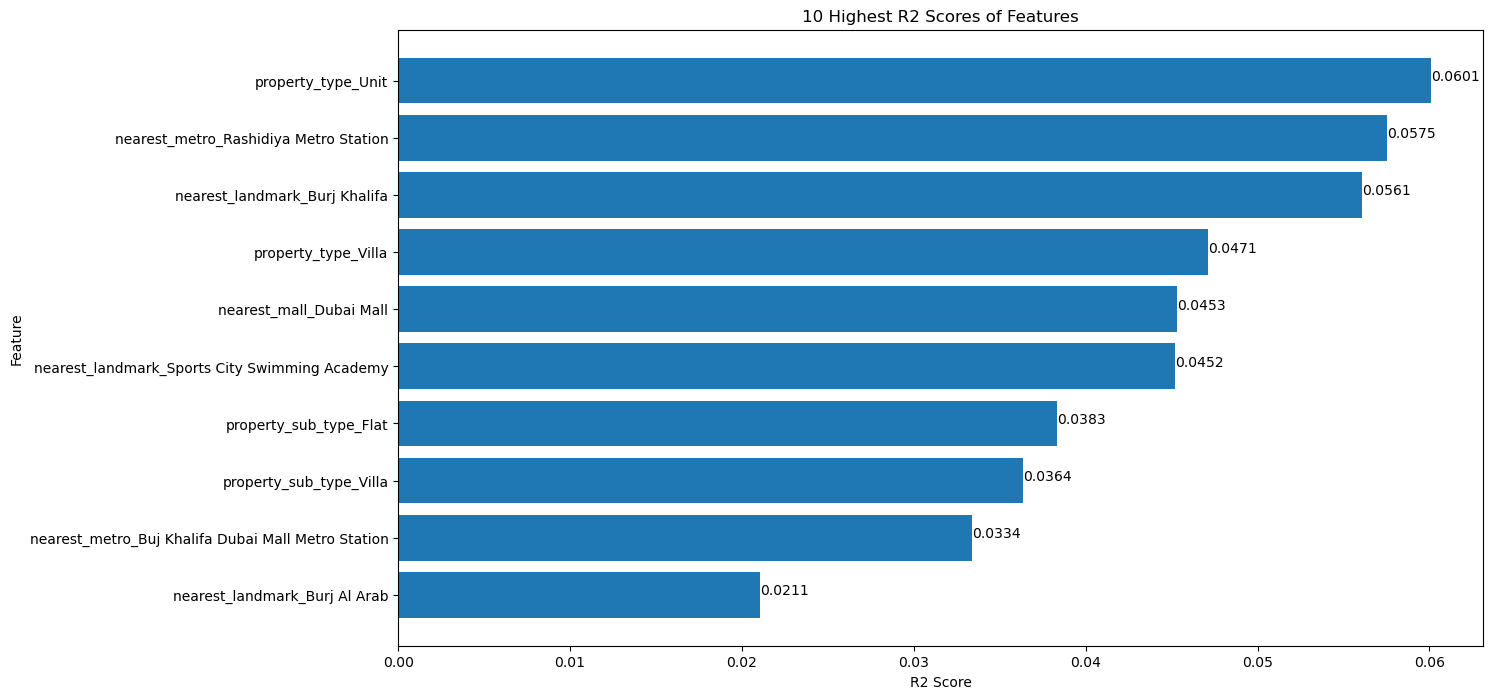

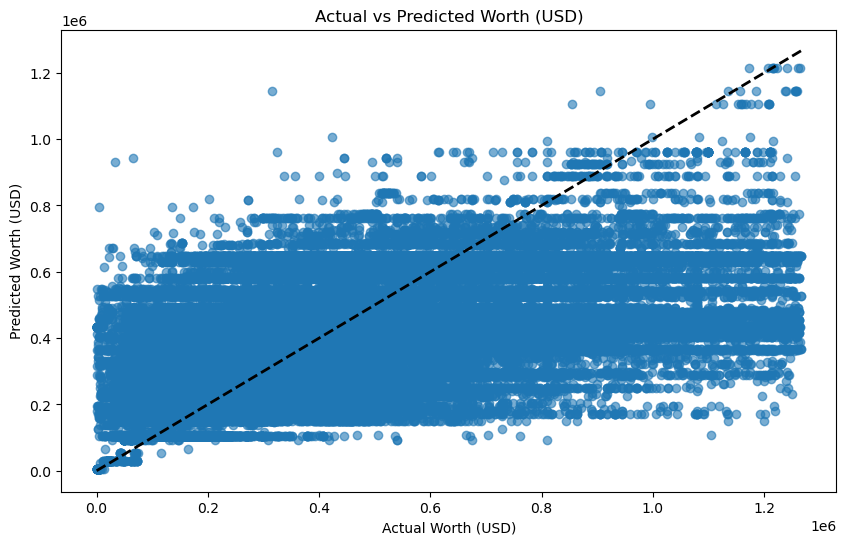

In [4]:
# turning the categorical features into dummy columns 
trans_land_mall_prop_sub_type_select = ['nearest_landmark', 'nearest_mall', 'property_type', 'property_sub_type', 'nearest_metro', 'actual_worth_usd']
trans_land_mall_prop_sub_type = trans[trans_land_mall_prop_sub_type_select]
#converts the specified categorical columns into dummy/indicator variables. The drop_first (first category in each column is dropped to avoid multicollinearity)
trans_encoded = pd.get_dummies(trans_land_mall_prop_sub_type, columns=['nearest_landmark', 'nearest_mall', 'property_type', 'property_sub_type', 'nearest_metro'], drop_first=True)

# defining what the input and output features are
X = trans_encoded.drop(['actual_worth_usd'], axis=1)
y = trans_encoded['actual_worth_usd']

# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=58) # 20% used for testing

# setting up the grid search for the hyperparameters (predetermined)
param_grid = {
    'n_estimators': [200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None],
    'min_samples_split': [10],
    'min_samples_leaf': [1]
}

# setting up the random forest regression model
rf = RandomForestRegressor()

# executing the gridsearch for hyperparameters (predetermined by previous code)
# created to perform a grid search with cross-validation.
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

# predicting on the training and test sets
y_train_pred = best_rf_model.predict(X_train)
y_test_pred = best_rf_model.predict(X_test)

# calculating evaluation metrics for training and test sets
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

# displaying what hyperparameters were used in the model
print('Best Parameters:', best_params)
print(f"Training Mean Squared Error: {mse_train}")
print(f"Training Root Mean Squared Error: {rmse_train}")
print(f"Training R^2 Score: {r2_train}")
print(f"Test Mean Squared Error: {mse_test}")
print(f"Test Root Mean Squared Error: {rmse_test}")
print(f"Test R^2 Score: {r2_test}")

# calculating R2 for each feature
r2_scores = []
features = X.columns
for feature in features:
    X_feature = X[[feature]]
    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_feature, y, test_size=0.2, random_state=42)
    rf_model_f = RandomForestRegressor(**best_params)
    rf_model_f.fit(X_train_f, y_train_f) # trains model on training data
    y_pred_f = rf_model_f.predict(X_test_f) # makes predictions on test data using trained model
    r2_f = r2_score(y_test_f, y_pred_f) # calculates R2 for the predictions against the actual values
    r2_scores.append(r2_f)

# creating a separate table with all the R2 scores of the features. 
# calculated by looking at the difference in the overall R2 scores when the feature is removed to when it is in the model.
r2_df = pd.DataFrame({'Feature': features, 'R2 Score': r2_scores})

# filtering out features with negative R2 scores
r2_df = r2_df[r2_df['R2 Score'] > 0]
top_r2_df = r2_df.nlargest(10, 'R2 Score') # extracting top 10 features

# plotting R2 scores with values displayed for the top 10 features
plt.figure(figsize=(14, 8))
plt.barh(top_r2_df['Feature'], top_r2_df['R2 Score'])
plt.xlabel('R2 Score')
plt.ylabel('Feature')
plt.title('10 Highest R2 Scores of Features')
plt.gca().invert_yaxis()

# adding values to bar graph
for index, value in enumerate(top_r2_df['R2 Score']):
    plt.text(value, index, f'{value:.4f}')
plt.show()

# scatter plot for actual vs predicted value (allows us to look at the overall trend of the data)
# also shows how line of best fit matches the model.
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Worth (USD)')
plt.ylabel('Predicted Worth (USD)')
plt.title('Actual vs Predicted Worth (USD)')
plt.show()

### Modeling - Snapshot:

- #### Model Results
    - The model results in a poor R-Squared value. The Test result should is around 0.4 and the training result is around 0.4. This is a low value meaning that this model is not great at predicting property values.
- #### R-Squared Bar chart:
    - The Bar chart shows the R-Squared values of the features in the model. 
    - Property type ('Unit' and 'Villa'), nearest metro station ('Rashidiya Metro Station'), and nearest landmark ('Burj Khalifa') have the highest R-Squared values and are the best predictors of rent in this dataset.
   
- #### Scatterplot: 
    -  The scatterplot compares the actual rent to the predicted rent. The predictions do not match the actual worth very well.
    

In [1]:
'''
# this is what the full grid search code would be (commented out so it does not run)

# setting up the grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# executing the grid search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='R2', verbose=2)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_
'''

"\n# this is what the full grid search code would be (commented out so it does not run)\n\n# setting up the grid search\nparam_grid = {\n    'n_estimators': [50, 100, 200],\n    'max_depth': [None, 10, 20, 30],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'max_features': ['sqrt', 'log2']\n}\n\n# executing the grid search\ngrid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='R2', verbose=2)\ngrid_search.fit(X_train, y_train)\nbest_rf_model = grid_search.best_estimator_\n"